<a href="https://colab.research.google.com/github/melyneca/Calendar/blob/main/Ship_Classifyyenii_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Önce uygun kütüphaneler yüklenir


In [ ]:
import torch
import pandas as pd
import torchvision
import numpy as np

Zip dosyası açılır ve extractall() ile dosyalar dışarı çıkarılır

In [ ]:
from zipfile import ZipFile
  
# Zip file directory
file_name = "/content/archive (1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    zip.extractall()

GPU kullanılabilir durumdayda GPU kullanılır, değilde CPU kullanılır

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Zip içindeki resimler dataset haline getirilir

In [ ]:
import os
from torch.utils.data import Dataset
from skimage import io

class ShipLoad(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    #Returns the lenght of the dataset
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    
    y_label = torch.tensor(int(self.annotations.iloc[index, 1])-1)

    #Applies the transformation
    if self.transform:
      image = self.transform(image)

    return (image, y_label)

Modelin öğrenebilmesi için resimlerin belli bir yapıda olması gerekir. Bu yüzden uygun transform fonksiyonları uygulanır
Dataset içinde siyah-beyaz resimler de bulunduğu için, tüm resimleri siyah-beyaz bir şekilde işlemek daha verimli oldu

In [ ]:
import torchvision.transforms as transforms

transform= transforms.Compose([
        transforms.ToPILImage(),
        #The dataset contains grayscaled images. 
        #Making all the images grayscaled works better
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(degrees=(-15,+15),translate=(0,0.2),scale=(0.75,1)),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        #The images should be normalized, If not the calculations can not be made 
        transforms.Normalize((0.5),(0.2))
        ])

Elimde bulunan veri setinde sadece train set sınıflandırılmıştı. Doğru bir şekilde modeli test etmek için tüm sınıflandırılmış resimleri %80-%20 şeklinde böldüm

In [ ]:
from torch.utils.data import random_split

#Loads all labeled images, and splits it to test and train data
data = ShipLoad('/content/train/train.csv', root_dir ='/content/train/images', transform = transform)
train_set_size = int(len(data) * 0.9)
test_set_size = len(data) - train_set_size
train_set, test_set = random_split(data, [train_set_size, test_set_size])

In [ ]:
print(f"Total data: {len(data)}")
print(f"Size of train data: {len(train_set)}")
print(f"Size of test data: {len(test_set)}")
image,label = train_set[3]
print(f"Shape of one image: {image.shape}")
print(f"Number of color channel: {image.shape[0]}")
print(f"Widht and Height: ({image.shape[1]},{image.shape[1]})")

Total data: 6252
Size of train data: 5626
Size of test data: 626
Shape of one image: torch.Size([1, 128, 128])
Number of color channel: 1
Widht and Height: (128,128)


In [ ]:
classes = ['Cargo','Military','Carrier','Cruise','Tankers']
print(f"Class of ships: {classes}")

Class of ships: ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tankers']


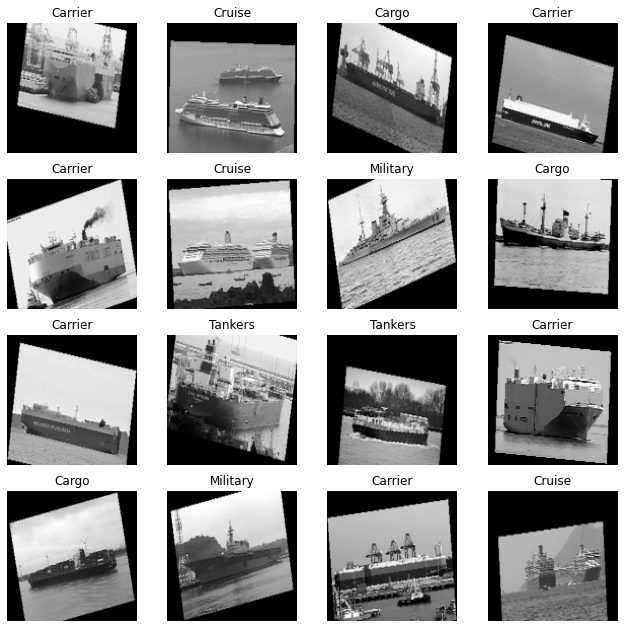

In [ ]:
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(11,11))

#Prints random images from dataset
for i in range(1,17):
  id = random.randint(0,len(train_set))
  images, label = train_set[id] 
  fig.add_subplot(4, 4, i)
  plt.imshow(images.squeeze(), cmap="gray")
  plt.axis('off');
  plt.title(classes[label]);


DataLoadder kullanılarak resimler batchler halinde yüklenir


In [ ]:
from torch.utils.data import DataLoader

train_data = DataLoader(dataset = train_set, batch_size= 32, shuffle= True)
# The model have never seen the test images before. No need to shuffle
test_data = DataLoader(dataset = test_set, batch_size= 32, shuffle= False)

In [ ]:
from torch.nn.modules.activation import Softmax
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, output_shape: int):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32,
                      out_channels=32, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, 
                      out_channels=32,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, 
                      out_channels=64, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,
                      out_channels=64, 
                      kernel_size = 3, 
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, 
                      out_channels=64,
                      kernel_size=2,
                      stride=2,
                      padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(in_features=(64*16*16), 
                      out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),          
            nn.Linear(in_features=1024, 
                      out_features=output_shape),
            nn.Softmax(1)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv3(self.conv2(self.conv1(x)))
        x = self.classifier(x)
        return x


In [ ]:
temp = torch.rand(size=[32,1,128,128]).to(device)

In [ ]:
modelCNN = CNN(output_shape=5).to(device)

In [ ]:
a = modelCNN(temp)
a.shape

torch.Size([32, 5])

In [ ]:
print(f"Model:\n{modelCNN}")

Model:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelCNN.parameters(), lr=0.0001)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
epochs = 100

In [ ]:
save = {
    "test_loss" : [],
    "test_acc" : [],
    "train_loss" : [],
    "train_acc" : [],
    "model" : {}
}

In [ ]:
load = False
if load:
  save = torch.load("model5.pt")

In [ ]:
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n-------")
  ### Training
    
  train_loss = 0
  train_acc = 0
  
  # Add a loop to loop through training batches
  for batch, (image, label) in enumerate(train_data):
    
    modelCNN.train() 
    image = image.to(device)
    label = label.type(torch.long).to(device)
         
    # Forward pass
    label_pred = modelCNN(image)

    # Calculate loss 
    loss = loss_fn(label_pred, label)
    train_loss += loss
    train_acc += accuracy_fn(y_true=label, y_pred= label_pred.argmax(dim=1)) 

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Optimizer
    optimizer.step()
  save["train_acc"].append(train_acc/len(train_data))
  save["train_loss"].append(train_loss/len(train_data))

  if epoch%5 == 0:
    train_acc = train_acc/len(train_data)
    train_loss = train_loss/len(train_data)
    save["model"] = modelCNN.state_dict
    torch.save(save,"model" + str(epoch) + ".pt")
    print(f"Train acc:{train_acc}")
    print(f"Train loss:{train_loss}")
        
    loss_test = 0
    acc_test = 0

    modelCNN.eval()
    with torch.inference_mode():
      for image_test, label_test in test_data:
            
        image_test = image_test.to(device)
        label_test = label_test.type(torch.long).to(device)
        
        label_pred = modelCNN(image_test)
        
        loss_test += loss_fn(label_pred, label_test)
        
        acc_test += accuracy_fn(y_true=label_test, y_pred=label_pred.argmax(dim=1))
        
        # Scale loss and acc
      loss_test /= len(test_data)
      acc_test /= len(test_data)
      save["test_acc"].append(acc_test)
      save["test_loss"].append(loss_test)

      print(f"test loss:{loss_test}")
      print(f"test acc:{acc_test}")

Epoch: 0
-------
Train acc:89.43673513986015
Train loss:1.0138893127441406
test loss:1.0442752838134766
test acc:86.42361111111111
Epoch: 1
-------
Epoch: 2
-------
Epoch: 3
-------
Epoch: 4
-------
Epoch: 5
-------
Train acc:89.27283653846153
Train loss:1.014685869216919
test loss:1.0502619743347168
test acc:84.51388888888889
Epoch: 6
-------
Epoch: 7
-------
Epoch: 8
-------
Epoch: 9
-------
Epoch: 10
-------
Train acc:89.6361451048951
Train loss:1.0136953592300415
test loss:1.061866283416748
test acc:83.73263888888889
Epoch: 11
-------


KeyboardInterrupt: ignored

In [ ]:

loss_test = 0
acc_test = 0

modelCNN.eval()
with torch.inference_mode():
  for image_test, label_test in test_data:
        
    image_test = image_test.to(device)
    label_test = label_test.type(torch.long).to(device)
    
    label_pred = modelCNN(image_test)
    
    loss_test += loss_fn(label_pred, label_test)
    
    acc_test += accuracy_fn(y_true=label_test, y_pred=label_pred.argmax(dim=1))
    
    # Scale loss and acc
  loss_test /= len(test_data)
  acc_test /= len(test_data)

  print(f"test loss:{loss_test}")
  print(f"test acc:{acc_test}")

test loss:1.045736312866211
test acc:85.05208333333334


In [ ]:
save["train_acc"]

AttributeError: ignored

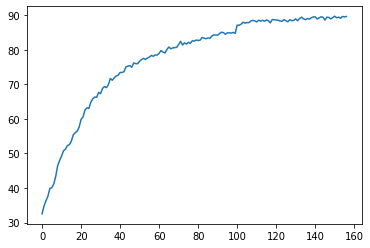

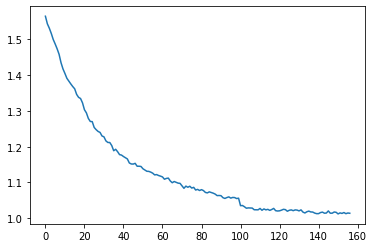

In [ ]:
plt.plot(range(len(save["train_acc"])),save["train_acc"])
plt.show()
plt.plot(range(len(save["train_loss"])),[i.cpu().detach().numpy() for i in save["train_loss"]])
plt.show()